In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from model_deltta import NB
from metrics import get_statistics

%matplotlib widget

# Process Data

In [3]:
df = pd.read_csv('bq_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['category'].notnull()]
df = df.fillna('') 
df = df.sort_values(by='date').reset_index(drop=True)
display(df)
print(df.info())

,date,commit_date,receiver,amount,category,commit_file_id
0,2019-05-01,2022-12-29,,-7656.0,INVESTING,OLD_EXCELL
1,2019-05-01,2022-12-29,,-804.0,CLOTHING,OLD_EXCELL
2,2019-05-01,2022-12-29,,-1212.0,TECHNOLOGY,OLD_EXCELL
3,2019-05-01,2022-12-29,,13176.0,OTHER-INCOME,OLD_EXCELL
4,2019-05-01,2022-12-29,,-1128.0,HOBBIES,OLD_EXCELL
...,...,...,...,...,...,...
1176,2023-09-25,2023-10-02,K-market Aurinkolah Helsinki,-37.1,FOOD,OP
1177,2023-09-28,2023-10-02,VR-YHTYMÄ OYJ,-14.9,COMMUTING,OP
1178,2023-09-29,2023-10-02,Rasmus Haapaniemi,-1000.0,INVESTING,OP
1179,2023-09-29,2023-10-02,MobilePay Sanna Maarit Marja Heikkilä,10.0,OTHER-INCOME,OP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1181 non-null   datetime64[ns]
 1   commit_date     1181 non-null   object        
 2   receiver        1181 non-null   object        
 3   amount          1181 non-null   float64       
 4   category        1181 non-null   object        
 5   commit_file_id  1181 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 55.5+ KB
None


# Training

In [30]:
df_train = df.loc[df['date'] < '2023-06-01']

str_features_train = df_train[['receiver']].to_numpy()
float_features_train = df_train[['amount']].to_numpy()
y_train = df_train['category'].to_numpy()

print(f'X_train: {str_features_train.shape}str + {float_features_train.shape}float')

model = NB()
model.fit(str_features=str_features_train, float_features=float_features_train, y=y_train)

X_train: (936, 1)str + (936, 1)float


# Validation

In [31]:
df_test = df.loc[df['date'] >= '2023-06-01']

str_features_test = df_test[['receiver']].to_numpy()
float_features_test = df_test[['amount']].to_numpy()
y_test = df_test['category'].to_numpy()

print(f'X_train: {str_features_test.shape}str + {float_features_test.shape}float')

y_predicted = model.predict(str_features=str_features_test, float_features=float_features_test)

X_train: (245, 1)str + (245, 1)float


# Stats

In [32]:
wa, stats = get_statistics(y_predicted, y_test, accepted_error=1)
display(stats)
print(f'Total weighted accuracy: {wa*100:.0f}%')

/Users/rasmus/Ohjelmointi/vscode/my_finance/ml_dev/metrics.py:26: FutureWarning: The provided callable <function mean at 0x7f7aa00c2b90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_stats = df_errors.groupby('actual_y').agg(count=('order', 'count'),


,actual_y,accuracy,count,place_avg,place_q90,place_q50
0,FOOD,0.977778,90,0.200000,1.0,0.0
1,HOUSEHOLD-ITEMS,0.171429,35,5.142857,9.6,6.0
2,COMMUTING,0.958333,24,0.250000,0.0,0.0
3,ENTERTAINMENT,0.736842,19,0.947368,2.0,1.0
4,LIVING,0.444444,18,2.722222,8.0,2.0
5,OTHER-INCOME,0.923077,13,0.230769,0.8,0.0
6,TECHNOLOGY,0.692308,13,0.769231,2.0,0.0
7,UNCATEGORIZED,0.153846,13,4.153846,6.0,5.0
8,HOBBIES,0.800000,5,1.200000,2.8,1.0
9,HEALTH,0.500000,4,2.000000,4.8,1.0


Total weighted accuracy: 73%


In [19]:
dates = []
scores = []
for date in pd.date_range(start='2019-05-01', end='2023-05-01', freq='M'):#(start='2019-05-01', end='2023-06-01')
    
    df_train = df.loc[df['date'] <= '2023-06-01']
    df_train = df_train.loc[df['date'] > date]
    str_features_train = df_train[['receiver']].to_numpy()
    float_features_train = df_train[['amount']].to_numpy()
    y_train = df_train['category'].to_numpy()

    if y_train.shape[0] == 0:
        print(date)

    model = NB()
    model.fit(str_features=str_features_train, float_features=float_features_train, y=y_train)

    df_test = df.loc[df['date'] >= '2023-06-02']
    str_features_test = df_test[['receiver']].to_numpy()
    float_features_test = df_test[['amount']].to_numpy()
    y_test = df_test['category'].to_numpy()
    y_predicted = model.predict(str_features=str_features_test, float_features=float_features_test)

    wa, stats = get_statistics(y_predicted, y_test, accepted_error=0)
    dates.append(date)
    scores.append(wa)

/Users/rasmus/Ohjelmointi/vscode/my_finance/ml_dev/metrics.py:26: FutureWarning: The provided callable <function mean at 0x7fb618092b90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_stats = df_errors.groupby('actual_y').agg(count=('order', 'count'),
/Users/rasmus/Ohjelmointi/vscode/my_finance/ml_dev/metrics.py:26: FutureWarning: The provided callable <function mean at 0x7fb618092b90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_stats = df_errors.groupby('actual_y').agg(count=('order', 'count'),
/Users/rasmus/Ohjelmointi/vscode/my_finance/ml_dev/metrics.py:26: FutureWarning: The provided callable <function mean at 0x7fb618092b90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be

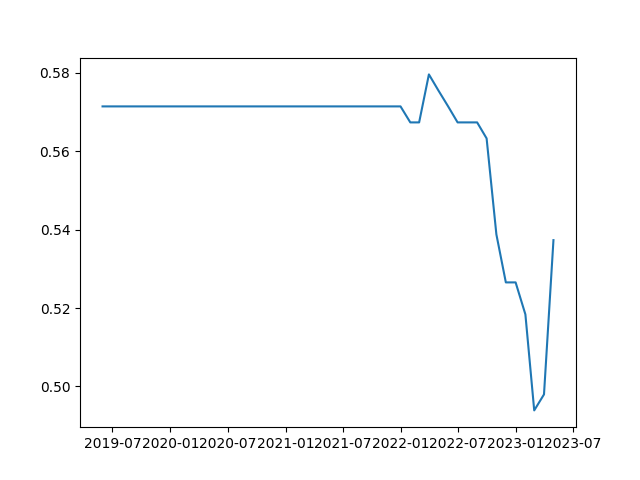

In [20]:
plt.figure(0)
plt.clf()

plt.plot(dates, scores)

plt.show()